# Imports

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys

sys.path.append("..")

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

from helpers.dataset import ContrastiveCIFAR10
from helpers.config import TrainingConfig, ResNetConfig, SSLConfig
from helpers.trainer import train
from models.encoder import ResNet
from models.ssl import SSLModel
from models.loss import NTXent, DCL, VICReg

# Load data

In [8]:
train_cfg = TrainingConfig(device=torch.device("mps"))

ds_train = ContrastiveCIFAR10("../data/cifar10/", train=True, download=True)
dl_train = DataLoader(
    ds_train,
    batch_size=train_cfg.batch_size,
    num_workers=train_cfg.num_workers,
    pin_memory=True,
    shuffle=True,
)

ds_test = CIFAR10("../data/cifar10/", train=False)

print(train_cfg, end="\n\n")
print(ds_train, end="\n\n")
print(ds_test)

Files already downloaded and verified
TrainingConfig(device=device(type='mps'), batch_size=1024, num_workers=10, learning_rate=0.002, weight_decay=1e-06, max_epoch=10)

Dataset ContrastiveCIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomResizedCrop(size=(32, 32), scale=(0.3, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 RandomApply(    ColorJitter(brightness=(0.6, 1.4), contrast=(0.9, 1.1), hue=(-0.1, 0.1)))
                 RandomGrayscale(p=0.1)
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/cifar10/
    Split: Test


torch.Size([3, 32, 32])


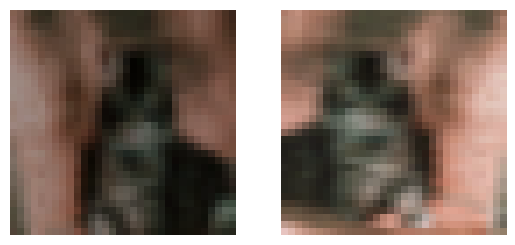

In [9]:
def imshow(*imgs):
    _, axes = plt.subplots(1, len(imgs))

    for i, img in enumerate(imgs):
        img = img / 2 + 0.5  # unnormalize
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_axis_off()

    plt.show()


idx = np.random.choice(range(len(ds_train)))
x_1, x_2 = ds_train[idx]

print(x_1.shape)
imshow(x_1, x_2)

# Train model

In [10]:
# equivalent to ResNet18
resnet_cfg = ResNetConfig(in_channels=3, num_stage=4, num_block_per_stage=2)
ssl_cfg = SSLConfig(dim_embedding=64 * 2 ** (4 - 1), num_hidden_proj=2)

encoder = ResNet(**resnet_cfg.__dict__)
model = SSLModel(encoder, **ssl_cfg.__dict__)

print(resnet_cfg, end="\n\n")
print(ssl_cfg, end="\n\n")

print(f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,d} learnable params", end="\n\n")
print(model)

ResNetConfig(in_channels=3, num_stage=4, num_block_per_stage=2, out_channels_first=64, kernel_size_first=7)

SSLConfig(dim_embedding=512, num_hidden_proj=2, dim_hidden_proj=None)

12,752,448 learnable params

SSLModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (_layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [11]:
loss = VICReg(normalize=True)
# loss = DCL()
# loss = NTXent()

loss_history = train(
    model,
    loss_func=loss,
    dl_train=dl_train,
    lr=train_cfg.learning_rate,
    max_epoch=train_cfg.max_epoch,
    device=train_cfg.device,
    weight_decay=train_cfg.weight_decay
)

Epoch 1 - step 49/49 - lr: 0.1952 -  loss: 24.5069
Epoch 2 - step 49/49 - lr: 0.1811 -  loss: 24.2310
Epoch 3 - step 49/49 - lr: 0.1592 -  loss: 24.1953
Epoch 4 - step 49/49 - lr: 0.1316 -  loss: 24.1927
Epoch 5 - step 49/49 - lr: 0.1010 -  loss: 24.1917
Epoch 6 - step 49/49 - lr: 0.0704 -  loss: 24.1906
Epoch 7 - step 49/49 - lr: 0.0428 -  loss: 24.1901
Epoch 8 - step 49/49 - lr: 0.0209 -  loss: 24.1893
Epoch 9 - step 49/49 - lr: 0.0068 -  loss: 24.1891
Epoch 10 - step 49/49 - lr: 0.0020 -  loss: 24.1886
